# Channels

In biological neurons, ion channels control the permeability of ions such as sodium, potassium, and calcium, which form the basis of neural signal generation and transmission. Different types of channels have their own kinetic properties and influence changes in membrane potential.

Channel modeling in `braincell` has the following notable advantages:
- Unified interface: whether it is a linear channel or a complex Markov model, all can be represented and integrated in a unified way.
- High flexibility: supports multiple types of currents and allows user-defined modeling.
- Compatible with `brainstate`'s automatic differentiation system: each state variable can be precisely differentiated automatically, supporting efficient training and optimization.
- High extensibility: through inheritance and composition mechanisms, channel models can easily build subclasses, allowing parameter modification and extension.

`braincell` is highly flexible. For `Channel`, `braincell` supports two ways of use: defining new ion channels, or using existing ones.

## Using existing channels

Let’s first explain how to use existing channels.

According to [different channel functions](https://elifesciences.org/articles/22152), we classify `Channel` into the following base classes:
- `Calcium Channels`
- `Potassium Channels`
- `Sodium Channels`
- `Potassium Calcium Channels`
- `Hyperpolarization-Activated Channels`
- `Leakage Channels`

`braincell` has already built in many specific channels under each base class, and you can use them freely.
If you want to learn more about the built-in channels, you can check the [Ion Channel Collection](../apis/braincell.channel.rst) for details.

When modeling neurons in practice, whether using existing channels or custom ones, we need to call them.
Of course, this call is quite simple, but we should also pay attention to some usage conventions.

Now let’s look at an example of modeling the `HTC` neuron:

In [4]:
import brainstate
import brainunit as u
import matplotlib.pyplot as plt

import braincell

In [5]:
class HTC(braincell.SingleCompartment):
    def __init__(
        self,
        size,
        gKL=0.01 * (u.mS / u.cm ** 2),
        V_initializer=brainstate.init.Constant(-65. * u.mV),
        solver: str = 'ind_exp_euler'
    ):
        super().__init__(size, V_initializer=V_initializer, V_th=20. * u.mV, solver=solver)

        self.area = 1e-3 / (2.9e-4 * u.cm ** 2)

        self.na = braincell.ion.SodiumFixed(size, E=50. * u.mV)
        self.na.add(INa=braincell.channel.INa_Ba2002(size, V_sh=-30 * u.mV))

        self.k = braincell.ion.PotassiumFixed(size, E=-90. * u.mV)
        self.k.add(IKL=braincell.channel.IK_Leak(size, g_max=gKL))
        self.k.add(IDR=braincell.channel.IKDR_Ba2002(size, V_sh=-30. * u.mV, phi=0.25))

        self.ca = braincell.ion.CalciumDetailed(
            size,
            C_rest=5e-5 * u.mM,
            tau=10. * u.ms,
            d=0.5 * u.um
        )
        self.ca.add(ICaL=braincell.channel.ICaL_IS2008(size, g_max=0.5 * (u.mS / u.cm ** 2)))
        self.ca.add(ICaN=braincell.channel.ICaN_IS2008(size, g_max=0.5 * (u.mS / u.cm ** 2)))
        self.ca.add(ICaT=braincell.channel.ICaT_HM1992(size, g_max=2.1 * (u.mS / u.cm ** 2)))
        self.ca.add(ICaHT=braincell.channel.ICaHT_HM1992(size, g_max=3.0 * (u.mS / u.cm ** 2)))

        self.kca = braincell.MixIons(self.k, self.ca)
        self.kca.add(IAHP=braincell.channel.IAHP_De1994(size, g_max=0.3 * (u.mS / u.cm ** 2)))

        self.Ih = braincell.channel.Ih_HM1992(size, g_max=0.01 * (u.mS / u.cm ** 2), E=-43 * u.mV)
        self.IL = braincell.channel.IL(size, g_max=0.0075 * (u.mS / u.cm ** 2), E=-70 * u.mV)

Through this example of the `HTC` neuron, it is clear that in practical modeling we only need to simply pass in the relevant channels.

It is worth noting, however, that the channels in this example have already been explicitly defined in the `braincell` codebase.
If you want to use other channels, you can either define your custom channels within the `braincell` codebase, or use `import` to bring in your custom channels.

### Use of `root_type`

When using each channel, we need to pay attention to the use of `root_type`. Generally speaking, calcium channels depend on the `Calcium` ion, potassium channels depend on the `Potassium` ion, and sodium channels depend on the `Sodium` ion.

In [6]:
braincell.channel.CalciumChannel.root_type

braincell.ion.Calcium

In [7]:
braincell.channel.PotassiumChannel.root_type

braincell.ion.Potassium

In [8]:
braincell.channel.SodiumChannel.root_type

braincell.ion.Sodium

Calcium-dependent potassium channels depend on both `Potassium` and `Calcium` ions.


In [9]:
braincell.channel.IAHP_De1994.root_type

typing.JointTypes[braincell.ion.Potassium, braincell.ion.Calcium]

For some special channels, such as `IL`, they do not depend on any type of ion, so their `root_type` is the cell.


In [10]:
braincell.channel.IL.root_type

braincell.HHTypedNeuron

### Adding ion channels

When performing single-cell modeling, we usually need to add ion channels to ions. If the use of `root_type` is not handled correctly, ion channels may not work properly. For example, sodium channels can only be added to sodium ions, and potassium channels can only be added to potassium ions. If you try to add a sodium channel to potassium ions, or add a potassium channel to calcium ions, it will result in an error.


In [11]:
na = braincell.ion.SodiumFixed(1)

In [12]:
na.add(ina=braincell.channel.INa_HH1952(1))

In [13]:
try:
    na.add(ik=braincell.channel.IK_HH1952(1))
except Exception as e:
    print(e)

Type does not match. IK_HH1952(
  size=(1,),
  name=None,
  g_max=10. * msiemens / cmeter2,
  phi=1.0,
  V_sh=-45. * mvolt
) requires a root with type of <class 'braincell.ion.Potassium'>, but the root now is <class 'braincell.ion.SodiumFixed'>.


### Simulating ion channels

We can also directly simulate ion channels without adding them to ions. This allows for more flexible use of ion channels. However, when simulating ion channels, we need to provide the required information such as the neuron's membrane potential and ion concentrations. Let’s take a calcium channel as an example.


In [14]:
ca = braincell.ion.CalciumFixed(1).pack_info()
V = -65 * u.mV

# The calcium channel to be simulated
can = braincell.channel.ICaL_IS2008(1)
can.init_state(V, ca)

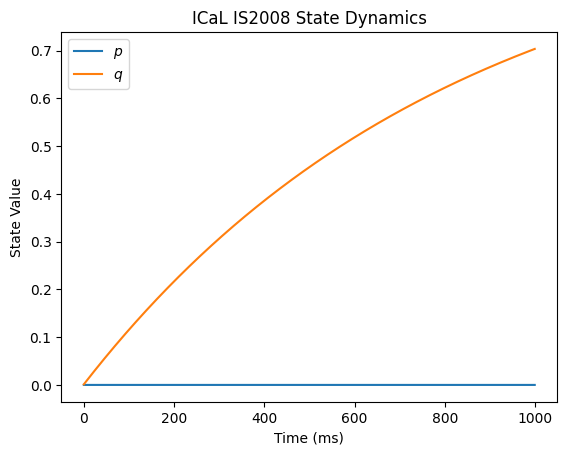

In [15]:
def run_can(i):
    dt = 0.1 * u.ms
    t = i * dt
    with brainstate.environ.context(i=i, t=t, dt=dt):
        braincell.ind_exp_euler_step(can, t, dt, V, ca)
    return can.p.value, can.q.value


indices = u.math.arange(1000)
ps, qs = brainstate.transform.for_loop(run_can, indices)

plt.plot(indices, ps, label='$p$')
plt.plot(indices, qs, label='$q$')
plt.xlabel('Time (ms)')
plt.ylabel('State Value')
plt.title('ICaL IS2008 State Dynamics')
plt.legend()
plt.show()

## Custom Channel Modeling

Now let’s explain how to use custom channels.

In `braincell`, we use the `IonChannel` class as the base class for channel modeling. All specific channel models should inherit from this class.

`IonChannel` provides the following interfaces to support key operations during simulation:
- `current`: compute the ionic current generated by the channel.
- `init_state`: initialize the channel’s state variables.
- `reset_state`: reset the channel’s state.
- `compute_derivative`: compute the derivatives of the channel’s internal state variables, used for the integrator.
- `pre_integral` and `post_integral`: operations before/after integration, usually unused.

`compute_derivative`, `pre_integral`, and `post_integral` are the core interfaces for integration and are typically implemented in specific channels. For a detailed introduction, see the [Differential Systems](../advanced_tutorial/differential_equation-zh.ipynb) section. These methods integrate seamlessly with `braincell`’s differential system. When customizing ion channels, you need to properly set the relevant interfaces to achieve the desired functionality.

`IonChannel` contains both `Ion` and `Channel`. Therefore, we define a wrapper base class `Channel` that directly inherits from `IonChannel`. For semantic clarity, we recommend using `Channel` when developing practical channel models.

Once the `Channel` base class is in place, it’s time to build specific types of channels. In practice, we want subclasses of `Channel` to implement the necessary methods that define the behavior of specific channel types.

Now let’s go through how to build custom channels for different purposes.

### Base Channel Modeling

First, when modeling a new channel, we need to determine whether it belongs to one of the existing base channel categories.

As mentioned earlier, `braincell` classifies `Channel` into the following types:
- `Calcium Channels`
- `Potassium Channels`
- `Sodium Channels`
- `Potassium Calcium Channels`
- `Hyperpolarization-Activated Channels`
- `Leakage Channels`

All of these channels directly inherit from the `Channel` base class. If the channel you want to customize belongs to one of these classes, refer directly to the following tutorials on subclass and specific channel modeling.
If your channel does not fit into these base classes, we will use the modeling of `Calcium Channels` as an example to show how to create a new base channel class.

In the `braincell.channel` module, all ion channels ultimately inherit from the unified abstract base class `Channel`. This class defines the minimal set of interfaces that every channel must implement, providing a unified framework for general modeling.

In practice, we often need to define intermediate base classes for different ion types. These type-specific base classes encapsulate channel type, input parameters, and interface structures, creating a clearer and more maintainable modeling hierarchy.

Here’s an example of modeling a `Calcium Channel`:

In [16]:
class CalciumChannel(braincell.Channel):
    # Specify the ion type this channel acts on
    root_type = braincell.ion.Calcium

    def pre_integral(self, V, Ca: braincell.IonInfo):
        pass

    def post_integral(self, V, Ca: braincell.IonInfo):
        pass

    def compute_derivative(self, V, Ca: braincell.IonInfo):
        pass

    def current(self, V, Ca: braincell.IonInfo):
        raise NotImplementedError

    def init_state(self, V, Ca: braincell.IonInfo, batch_size=None):
        pass

    def reset_state(self, V, Ca: braincell.IonInfo, batch_size=None):
        pass

The above code easily completes the modeling of `CalciumChannel`.

Looking at the code, the most important part is defining `root_type = Calcium`.
This is the core of `CalciumChannel`, which tells `braincell`:
this channel only acts on `Calcium`, and the parameter `Ca` must be of type `IonInfo`, representing the calcium ion state.
This ensures that when you implement interfaces such as `current` or `compute_derivative`, you can access the corresponding ion information.

Once you have defined `CalciumChannel`, all subsequent specific calcium channel subclasses can inherit from it:
at this point you no longer need to worry about the source of `IonInfo`, since `braincell` will automatically pass the `Calcium` ion to you.

At the same time, when modeling a new base channel class, you need to pay attention to defining its interfaces.
These interfaces can follow those defined in `Channel`, or they can be customized depending on actual needs.

By constructing type-specific base classes like `CalciumChannel`, we can:
- Clearly specify the ion type applicable to the model.
- Provide a unified interface.
- Simplify the writing of downstream models.
- Improve code reusability and maintainability.

This design also applies to sodium channels (`SodiumChannel`), potassium channels (`PotassiumChannel`), and other ion channels,
and it is recommended as the standard approach for writing custom channel models.

### Specific Channel Modeling

Next, let’s use the code for `ICaT_HP1992` as an example to demonstrate how to define a custom ion channel model.

The `ICaT_HP1992` ion channel is a calcium channel model, based on the calcium channel model proposed by Huguenard & Prince in 1992:
[<A novel T-type current underlies prolonged Ca(2+)-dependent burst firing in GABAergic neurons of rat thalamic reticular nucleus>](https://pubmed.ncbi.nlm.nih.gov/1403085/).

Modeling it only requires referring to the specific equations and implementing them directly in code.

First, we define the parameters:

- $p$ and $q$ are two gating variables for activation and inactivation.
- $\phi_p = 5^{\frac{T-24}{10}}$ and $\phi_q = 3^{\frac{T-24}{10}}$ are temperature-dependent factors ($T$ is the temperature in Celsius).
- $E_{Ca}$ is the reversal potential of the calcium channel.
- $p_{\infty}$ and $q_{\infty}$ are the steady-state activation/inactivation functions of $p$ and $q$ (voltage-dependent).
- $\tau_p$ and $\tau_q$ are voltage-dependent time constants.
- $\phi_p$ and $\phi_q$ are temperature correction factors.
- $g_{max}$ is the maximum conductance.
- $V$ is the membrane potential, and $E_{Ca}$ is the calcium reversal potential.
- $V_{sh}$ is the membrane potential shift.


In [17]:
class ICaT_HP1992(CalciumChannel):
    root_type = braincell.ion.Calcium

    def __init__(
        self,
        size: brainstate.typing.Size,
        T: brainstate.typing.ArrayLike = u.celsius2kelvin(36.),
        T_base_p: brainstate.typing.ArrayLike = 5.,
        T_base_q: brainstate.typing.ArrayLike = 3.,
        g_max=1.75 * (u.mS / u.cm ** 2),
        V_sh=-3. * u.mV,
        phi_p=None,
        phi_q=None,
    ):
        super().__init__(size)

        T = u.kelvin2celsius(T)
        phi_p = T_base_p ** ((T - 24) / 10) if phi_p is None else phi_p
        phi_q = T_base_q ** ((T - 24) / 10) if phi_q is None else phi_q
        # parameters
        self.phi_p = brainstate.init.param(phi_p, self.varshape, allow_none=False)
        self.phi_q = brainstate.init.param(phi_q, self.varshape, allow_none=False)
        self.g_max = brainstate.init.param(g_max, self.varshape, allow_none=False)
        self.T = brainstate.init.param(T, self.varshape, allow_none=False)
        self.T_base_p = brainstate.init.param(T_base_p, self.varshape, allow_none=False)
        self.T_base_q = brainstate.init.param(T_base_q, self.varshape, allow_none=False)
        self.V_sh = brainstate.init.param(V_sh, self.varshape, allow_none=False)

Then for $p_{\infty}$ we have

$$
p_{\infty} = \frac{1}{1 + \exp\!\left[-\frac{V + 52 - V_{sh}}{7.4}\right]}
$$


In [18]:
    def f_p_inf(self, V):
        V = (V - self.V_sh).to_decimal(u.mV)
        return 1. / (1. + u.math.exp(-(V + 52.) / 7.4))

For $\tau_p$ we have:

$$
\tau_p = 3 + \frac{1}{\exp\!\left(\frac{V + 27 - V_{sh}}{10}\right) + \exp\!\left(-\frac{V + 102 - V_{sh}}{15}\right)}
$$


In [19]:
    def f_p_tau(self, V):
        V = (V - self.V_sh).to_decimal(u.mV)
        return 3. + 1. / (u.math.exp((V + 27.) / 10.) +
                          u.math.exp(-(V + 102.) / 15.))

For $q_{\infty}$ we have:

$$
q_{\infty} = \frac{1}{1 + \exp\!\left(\frac{V + 80 - V_{sh}}{5}\right)}
$$


In [20]:
    def f_q_inf(self, V):
        V = (V - self.V_sh).to_decimal(u.mV)
        return 1. / (1. + u.math.exp((V + 80.) / 5.))

For $\tau_q$ we have:

$$
\tau_q = 85 + \frac{1}{\exp\!\left(\frac{V + 48 - V_{sh}}{4}\right) + \exp\!\left(-\frac{V + 407 - V_{sh}}{50}\right)}
$$


In [21]:
    def f_q_tau(self, V):
        V = (V - self.V_sh).to_decimal(u.mV)
        return 85. + 1. / (u.math.exp((V + 48.) / 4.) + u.math.exp(-(V + 407.) / 50.))

At the same time, we need to set the `state`:

In [22]:
    def init_state(self, V, Ca: braincell.IonInfo, batch_size: int = None):
        self.p = braincell.DiffEqState(brainstate.init.param(u.math.zeros, self.varshape, batch_size))
        self.q = braincell.DiffEqState(brainstate.init.param(u.math.zeros, self.varshape, batch_size))

In [23]:
    def reset_state(self, V, Ca, batch_size=None):
        self.p.value = self.f_p_inf(V)
        self.q.value = self.f_q_inf(V)
        if batch_size is not None:
            assert self.p.value.shape[0] == batch_size
            assert self.q.value.shape[0] == batch_size

For $\frac{dp}{dt}$ and $\frac{dq}{dt}$, we have:

$$\frac{dp}{dt} = \frac{\phi_p \cdot (p_{\infty} - p)}{\tau_p}$$

$$\frac{dq}{dt} = \frac{\phi_q \cdot (q_{\infty} - q)}{\tau_q}$$


In [24]:
    def compute_derivative(self, V, Ca: braincell.IonInfo):
        self.p.derivative = self.phi_p * (self.f_p_inf(V) - self.p.value) / self.f_p_tau(V) / u.ms
        self.q.derivative = self.phi_q * (self.f_q_inf(V) - self.q.value) / self.f_q_tau(V) / u.ms

For the overall $I_{CaT}$, we have:

$$I_{CaT} = g_{max} \cdot p^2 \cdot q \cdot (V - E_{Ca})$$


In [25]:
    def current(self, V, Ca: braincell.IonInfo):
        return self.g_max * self.p.value * self.p.value * self.q.value * (Ca.E - V)

At this point, we have completed the modeling of `ICaT_HP1992`.

In `braincell`, we usually use `__init__` to define the constructor, and during class initialization, we accept relevant parameters such as `size`, `phi_p`, `phi_q`, etc.

Additionally, we should use `brainstate.init.param` to register `phi_p`, `phi_q`, and `g_max` as trainable parameters, which enables support for subsequent automatic differentiation, updates, and batch computations.

At the same time, when defining interfaces, we need to refer to the actual situation or the specific formulas; for example, the `compute_derivative` interface follows the specific formulas.

Through this modeling, the subclass channels gain the following functionalities:

* Encapsulates the calcium current kinetics framework in the form of $p^2 q$.
* Manages the initialization, updating, and current calculation of the state variables $p$ and $q$.
* Allows concrete parameters to be defined by the subclass.
* Supports batch computation and parameter differentiability.

This modeling framework is highly versatile and flexible, suitable for various requirements encountered in practical modeling.


## Existing Channel Examples

After explaining how to use existing channels and create custom channels, we introduce some specific channel examples. Whether using built-in channels or creating new custom channels, these examples provide good references and can guide you when you have questions about channel modeling. The following channel examples show specific electrophysiological properties and modeling approaches.

### Calcium Channels

#### Electrophysiological Properties

Calcium channels are highly important membrane channels responsible for regulating the transmembrane flow of calcium ions. Calcium ions in the nervous system not only participate in membrane potential changes but also play key roles in:

* Action potential generation and maintenance: Certain neuron types rely on calcium channels to trigger or sustain firing rhythms.
* Synaptic transmission: Calcium influx triggers neurotransmitter release.
* Intracellular signaling: Calcium can regulate protein kinase activity, gene expression, enzymatic reactions, and more.
* Calcium-dependent channel regulation: Many potassium or mixed channels are also regulated by calcium concentration.

Calcium channels typically exhibit slow activation, calcium-dependent inactivation, and high selectivity. They often work together with calcium pumps and buffering proteins to maintain calcium homeostasis.

![Calcium Channel](../_static/calciumchannel.png)

#### Modeling Implementation

In `braincell`, calcium channels are modeled by inheriting from `CalciumChannel`, which itself inherits from `Channel` and is part of the `IonChannel` system.

In practice, we need to implement relevant interfaces, such as `current(V, Ca)` and `compute_derivative(V, Ca)`.
The `Ca` parameter is of type `IonInfo` and contains local calcium concentration information for the channel. Detailed information about `IonInfo` will be introduced in the `Ion` section.

Through these interfaces, we can build calcium channels with complex dynamics, such as dual voltage and calcium regulation, calcium-dependent inactivation, and steady-state activation gating.

After understanding the basic modeling, let's look at a practical example: `ICaN_IS2008`.

This is a calcium-activated non-selective cation channel model proposed by Inoue & Strowbridge in 2008.
`braincell` follows a fixed naming convention for ion channels, in the format `ChannelType_LiteratureID`. Most channels in `braincell` follow this convention, which makes them easy to reference.

For the model itself, the current is described by the following formulas:

$$
\begin{aligned}
I_{\text{CAN}} &= g_{\text{max}} \cdot M([\mathrm{Ca}^{2+}]_i) \cdot p \cdot (V - E) \\\\
M([\mathrm{Ca}^{2+}]_i) &= \frac{[\mathrm{Ca}^{2+}]_i}{0.2 + [\mathrm{Ca}^{2+}]_i} \\\\
\frac{dp}{dt} &= \frac{\phi \cdot (p_\infty - p)}{\tau_p} \\\\
p_\infty &= \frac{1}{1 + \exp\left(-\frac{V + 43}{5.2}\right)} \\\\
\tau_p &= \frac{2.7}{\exp\left(-\frac{V + 55}{15}\right) + \exp\left(\frac{V + 55}{15}\right)} + 1.6
\end{aligned}
$$

Where:

* $M$ is the calcium-dependent activation function
* $p$ is the voltage-gated activation variable
* $\phi$ is the temperature factor
* $E$ is the reversal potential
* $g_{\text{max}}$ is the maximal conductance

The following is the code implementation of this model:


In [26]:
class ICaN_IS2008(CalciumChannel):
    def __init__(
        self,
        size,
        E=10. * u.mV,
        g_max=1. * (u.mS / u.cm ** 2),
        phi=1.,
        name=None,
    ):
        super().__init__(size=size, name=name)
        self.E = brainstate.init.param(E, self.varshape, allow_none=False)
        self.g_max = brainstate.init.param(g_max, self.varshape, allow_none=False)
        self.phi = brainstate.init.param(phi, self.varshape, allow_none=False)

    def init_state(self, V, Ca: braincell.IonInfo, batch_size: int = None):
        self.p = braincell.DiffEqState(brainstate.init.param(u.math.zeros, self.varshape, batch_size))

    def reset_state(self, V, Ca: braincell.IonInfo, batch_size=None):
        V = V.to_decimal(u.mV)
        self.p.value = 1.0 / (1 + u.math.exp(-(V + 43.) / 5.2))

    def compute_derivative(self, V, Ca: braincell.IonInfo):
        V = V.to_decimal(u.mV)
        p_inf = 1.0 / (1 + u.math.exp(-(V + 43.) / 5.2))
        tau_p = 2.7 / (u.math.exp(-(V + 55.) / 15.) + u.math.exp((V + 55.) / 15.)) + 1.6
        self.p.derivative = self.phi * (p_inf - self.p.value) / tau_p / u.ms

    def current(self, V, Ca: braincell.IonInfo):
        M = Ca.C / (Ca.C + 0.2 * u.mM)
        g = self.g_max * M * self.p.value
        return g * (self.E - V)

In this example, we created a specific calcium channel subclass that inherits from `CalciumChannel`. Observing the code, we can see that `CalciumChannel` is very flexible when modeling a specific channel: you only need to set the relevant parameters and express the different interfaces in code according to the formulas.

### Potassium Channels

#### Electrophysiological Properties

Potassium channels are the main hyperpolarizing channels in neurons, determining the repolarization process of action potentials and the stability of the resting membrane potential. Their functions in neurons include:

* Action potential repolarization: During an action potential, sodium channels cause depolarization, and potassium channels open to allow K$^+$ efflux, returning the membrane potential to resting levels.
* Controlling excitability: Some potassium channels have delayed activation or calcium-dependent properties, regulating firing frequency, adaptation, and sustained excitability.
* Modulating network rhythms: Certain potassium channels play important roles in rhythmic firing and oscillations.

Potassium channels have wide-ranging functions, and their kinetic modeling is crucial in computational neuroscience.

![Potassium Channel](../_static/potassiumchannel.png)

#### Modeling Implementation

In `braincell`, potassium channels are modeled by inheriting from `PotassiumChannel`, which itself inherits from `Channel`.

When implementing a specific potassium channel, similar interfaces to those used for calcium channels are typically required.

Let’s look at a specific example: `IKNI_Ya1989`, which helps illustrate the approach.

This model was first proposed by Yamada in 1989 and represents a classic slow non-inactivating potassium channel used to explain frequency regulation during the afterhyperpolarization (AHP) period.

The model is described by the following formulas:

$$
\begin{aligned}
I_{M} &= \bar{g}_M \cdot p \cdot (V - E_K) \\\\
\frac{dp}{dt} &= \frac{p_{\infty}(V) - p}{\tau_p(V)} \\\\
p_{\infty}(V) &= \frac{1}{1 + \exp\left(-\frac{V - V_{\text{sh}} + 35}{10}\right)} \\\\
\tau_p(V) &= \frac{\tau_{\max}}{3.3 \exp\left(\frac{V - V_{\text{sh}} + 35}{20}\right) + \exp\left(-\frac{V - V_{\text{sh}} + 35}{20}\right)}
\end{aligned}
$$

Where:

* $V$ is the membrane potential
* $E_K$ is the potassium reversal potential
* $\bar{g}_M$ is the maximal conductance
* $p$ is the gating variable
* $V_{\text{sh}}$ is the membrane potential shift
* $\tau_{\max}$ is the maximal time constant
* $p_{\infty}$ is the steady-state activation function
* $\tau_p$ is the activation time constant

The following is the code implementation:


In [27]:
from braincell.channel import PotassiumChannel


class IKNI_Ya1989(PotassiumChannel):
    def __init__(
        self,
        size,
        g_max=0.004 * (u.mS * u.cm ** -2),
        phi_p=1.,
        phi_q=1.,
        tau_max=4e3 * u.ms,
        V_sh=0. * u.mV,
        name=None,
    ):
        super().__init__(size=size, name=name)

        self.g_max = brainstate.init.param(g_max, self.varshape, allow_none=False)
        self.tau_max = brainstate.init.param(tau_max, self.varshape, allow_none=False)
        self.V_sh = brainstate.init.param(V_sh, self.varshape, allow_none=False)
        self.phi_p = brainstate.init.param(phi_p, self.varshape, allow_none=False)
        self.phi_q = brainstate.init.param(phi_q, self.varshape, allow_none=False)

    def init_state(self, V, Ca: braincell.IonInfo, batch_size: int = None):
        self.p = braincell.DiffEqState(brainstate.init.param(u.math.zeros, self.varshape, batch_size))

    def reset_state(self, V, K: braincell.IonInfo, batch_size=None):
        self.p.value = self.f_p_inf(V)
        if isinstance(batch_size, int):
            assert self.p.value.shape[0] == batch_size

    def compute_derivative(self, V, K: braincell.IonInfo):
        self.p.derivative = self.phi_p * (self.f_p_inf(V) - self.p.value) / self.f_p_tau(V)

    def current(self, V, K: braincell.IonInfo):
        return self.g_max * self.p.value * (K.E - V)

    def f_p_inf(self, V):
        V = (V - self.V_sh).to_decimal(u.mV)
        return 1. / (1. + u.math.exp(-(V + 35.) / 10.))

    def f_p_tau(self, V):
        V = (V - self.V_sh).to_decimal(u.mV)
        temp = V + 35.
        return self.tau_max / (3.3 * u.math.exp(temp / 20.) + u.math.exp(-temp / 20.))

From this example, we can see that `PotassiumChannel` provides a unified interface, and `IKNI_Ya1989` can easily construct a biologically meaningful ion channel model using simple mathematical expressions.

In practical applications, we can further build subclasses under a subclass.

For example, first construct `IKK2_pq_ss`, which inherits from `PotassiumChannel`. Later, we can construct `KK2A_HM1992` inheriting from `IKK2_pq_ss` and extend the original functionality of `IKK2_pq_ss` in `KK2A_HM1992`. This workflow facilitates large-scale modeling and improves efficiency. If you are interested in this part, you can refer to our [Ion Channel Collection](https://braincell.readthedocs.io/latest/apis/braincell.channel.html) to see how `braincell` implements it in detail.

### Sodium Channels

#### Electrophysiological Properties

Sodium channels are indispensable excitatory channels in neurons, playing a central role in the initiation and rising phase of action potentials. When the membrane potential reaches a certain threshold, sodium channels rapidly activate, causing Na$^+$ influx and rapid depolarization of the membrane.

Sodium channels have a typical dual-gate mechanism:

* Activation gate: responds quickly to membrane potential changes, determining whether the channel opens.
* Inactivation gate: responds slightly slower, closing the channel and causing inactivation.

This dual-gate structure allows sodium channels to exhibit fast activation and fast inactivation dynamics, which is the fundamental mechanism for the rapid rise and fall of action potentials.

![Sodium Channel](../_static/sodiumchannel.png)

Sodium channels are highly sensitive to membrane potential changes, and their kinetics determine the regulation of neuronal excitability. In the classical HH model, the sodium current is typically represented as:

$$
I_{Na} = \bar{g}_{Na} \cdot m^3 h \cdot (V - E_{Na})
$$

Where:

* $m$ is the activation variable
* $h$ is the inactivation variable
* $g_{Na}$ is the maximal conductance
* $E_{Na}$ is the sodium reversal potential

#### Modeling Implementation

In `braincell`, sodium channels are modeled by inheriting the `SodiumChannel` class, which, like the others, is a subclass of `Channel`.

As with calcium and potassium channels, we only need to define the corresponding interfaces to complete the modeling.

Here is a specific example: `INa_p3q_markov`.

Notably, a different channel naming convention is used here. `INa_p3q_markov` is named based on the formula structure, representing a current in the form of $p^3 q$ and modeled using Markov kinetics. This is another naming convention in `braincell`: `channel type_name_current form_model`. Some ion channels adopt this convention.

`INa_p3q_markov` is a sodium channel model using Markov chain kinetics, where the current is controlled by activation variable $p$ and inactivation variable $q$:

$$
\begin{aligned}
I_{\mathrm{Na}} &= g_{\mathrm{max}} \cdot p^3 \cdot q \cdot (V - E_{Na}) \\\\
\frac{dp}{dt} &= \phi \cdot (\alpha_p (1 - p) - \beta_p p) \\\\
\frac{dq}{dt} &= \phi \cdot (\alpha_q (1 - q) - \beta_q q)
\end{aligned}
$$

Where:

* $p$ is the activation variable
* $q$ is the inactivation variable
* $\phi$ is the temperature factor
* $g_{max}$ is the maximal conductance
* $E_{Na}$ is the sodium reversal potential

The corresponding code implementation is as follows:


In [28]:
from braincell.channel import SodiumChannel


class INa_p3q_markov(SodiumChannel):
    def __init__(
        self,
        size,
        g_max=90. * (u.mS / u.cm ** 2),
        phi=1.,
        name=None,
    ):
        super().__init__(size=size, name=name)
        self.phi = brainstate.init.param(phi, self.varshape, allow_none=False)
        self.g_max = brainstate.init.param(g_max, self.varshape, allow_none=False)

    def init_state(self, V, Na: braincell.IonInfo, batch_size=None):
        self.p = braincell.DiffEqState(brainstate.init.param(u.math.zeros, self.varshape, batch_size))
        self.q = braincell.DiffEqState(brainstate.init.param(u.math.zeros, self.varshape, batch_size))

    def reset_state(self, V, Na: braincell.IonInfo, batch_size=None):
        self.p.value = self.f_p_alpha(V) / (self.f_p_alpha(V) + self.f_p_beta(V))
        self.q.value = self.f_q_alpha(V) / (self.f_q_alpha(V) + self.f_q_beta(V))

    def compute_derivative(self, V, Na: braincell.IonInfo):
        self.p.derivative = self.phi * (
            self.f_p_alpha(V) * (1. - self.p.value) - self.f_p_beta(V) * self.p.value) / u.ms
        self.q.derivative = self.phi * (
            self.f_q_alpha(V) * (1. - self.q.value) - self.f_q_beta(V) * self.q.value) / u.ms

    def current(self, V, Na: braincell.IonInfo):
        return self.g_max * self.p.value ** 3 * self.q.value * (Na.E - V)

    def f_p_alpha(self, V):
        raise NotImplementedError

    def f_p_beta(self, V):
        raise NotImplementedError

    def f_q_alpha(self, V):
        raise NotImplementedError

    def f_q_beta(self, V):
        raise NotImplementedError

Like the other two types of ion channels, our sodium channel modeling retains high flexibility.

### Potassium Calcium Channels

#### Electrophysiological Properties

Potassium calcium (KCa) channels are widely present in neurons, and their activation depends not only on membrane potential but also on intracellular calcium concentration.

These channels play a crucial role in regulating neuronal excitability, afterhyperpolarization, and firing frequency. They are typically activated following calcium influx, promoting K$^+$ efflux and returning the membrane potential to rest or hyperpolarized states.

#### Modeling Implementation

Potassium calcium channels are commonly abbreviated as `KCa` channels in electrophysiology, and we adopt the same naming in modeling for code simplicity.

In `braincell`, KCa channels are modeled by directly inheriting the `KCaChannel` class, which is also a subclass of `Channel`.

As with the previously described channels, we only need to define the corresponding interfaces to complete the modeling.

Here we give an example: `IAHP_De1994`.

The `IAHP_De1994` model, proposed by Destexhe et al. in 1994, inherits from `KCaChannel` and is used to simulate the dynamics of slow calcium-dependent potassium channels. The expressions are as follows:

$$
\begin{aligned}
(\text{closed}) + n \mathrm{Ca}_{i}^{2+} \underset{\beta}{\stackrel{\alpha}{\rightleftharpoons}} (\text{open})
\end{aligned}
$$

$$
\begin{aligned}
I_{AHP} &= g_{\mathrm{max}} p^2 (V - E_K) \\\\
{dp \over dt} &= \phi {p_{\infty}(V, [Ca^{2+}]_i) - p \over \tau_p(V, [Ca^{2+}]_i)} \\\\
p_{\infty} &= \frac{\alpha[Ca^{2+}]_i^n}{\alpha[Ca^{2+}]_i^n + \beta} \\\\
\tau_p &= \frac{1}{\alpha[Ca^{2+}]_i + \beta}
\end{aligned}
$$

Where:

* $p$ is the channel state variable
* $\alpha, \beta$ are the channel opening/closing rate constants
* $n$ is the number of calcium ions bound
* $\phi$ is the temperature factor
* $g_{\text{max}}$ is the maximal conductance
* $E_K$ is the potassium reversal potential

The code implementation is as follows:


In [29]:
from braincell.channel import KCaChannel


class IAHP_De1994(KCaChannel):
    def __init__(
        self,
        size: brainstate.typing.Size,
        n=2,
        g_max=10. * (u.mS / u.cm ** 2),
        alpha=48.,
        beta=0.09,
        phi=1.,
        name=None,
    ):
        super().__init__(size=size, name=name)
        self.g_max = brainstate.init.param(g_max, self.varshape, allow_none=False)
        self.n = brainstate.init.param(n, self.varshape, allow_none=False)
        self.alpha = brainstate.init.param(alpha, self.varshape, allow_none=False)
        self.beta = brainstate.init.param(beta, self.varshape, allow_none=False)
        self.phi = brainstate.init.param(phi, self.varshape, allow_none=False)

    def init_state(self, V, K: braincell.IonInfo, Ca: braincell.IonInfo, batch_size=None):
        self.p = braincell.DiffEqState(brainstate.init.param(u.math.zeros, self.varshape, batch_size))

    def reset_state(self, V, K: braincell.IonInfo, Ca: braincell.IonInfo, batch_size=None):
        C2 = self.alpha * u.math.power(Ca.C / u.mM, self.n)
        C3 = C2 + self.beta
        if batch_size is None:
            self.p.value = u.math.broadcast_to(C2 / C3, self.varshape)
        else:
            self.p.value = u.math.broadcast_to(C2 / C3, (batch_size,) + self.varshape)
            assert self.p.value.shape[0] == batch_size

    def compute_derivative(self, V, K: braincell.IonInfo, Ca: braincell.IonInfo):
        C2 = self.alpha * u.math.power(Ca.C / u.mM, self.n)
        C3 = C2 + self.beta
        self.p.derivative = self.phi * (C2 / C3 - self.p.value) * C3 / u.ms

    def current(self, V, K: braincell.IonInfo, Ca: braincell.IonInfo):
        return self.g_max * self.p.value * self.p.value * (K.E - V)

In fact, the modeling approach for these examples is highly consistent, with no differences in implementation.

### Hyperpolarization-Activated Channels

#### Electrophysiological Properties

Hyperpolarization-activated channels are cation channels activated when the membrane potential hyperpolarizes. They play key regulatory roles in pacemaker neurons of the heart and certain types of central nervous system neurons:

* Regulate resting membrane potential: depolarizing currents at rest stabilize the membrane potential and prevent excessive hyperpolarization.
* Participate in rhythmic firing: in structures like the thalamus, they help maintain intrinsic rhythmic firing.
* Excitability regulation: they can reduce neuronal input resistance, decreasing the cell's sensitivity to inputs.

#### Modeling Implementation

Since `braincell` does not have many built-in hyperpolarization-activated channels, we simply let specific hyperpolarization-activated channels inherit from the `Channel` class. This does not affect practical use.

Here is an example: `Ih_HM1992`.

`Ih_HM1992` was proposed by Huguenard & McCormick in 1992 as a hyperpolarization-activated cation current model. Its dynamics are described by:

$$
\begin{aligned}
I_h &= g_{\mathrm{max}} p \\\\
\frac{dp}{dt} &= \phi \frac{p_{\infty} - p}{\tau_p} \\\\
p_{\infty} &= \frac{1}{1+\exp((V+75)/5.5)} \\\\
\tau_p &= \frac{1}{\exp(-0.086 V - 14.59) + \exp(0.0701 V - 1.87)}
\end{aligned}
$$

Where:

* $p$ is the activation variable
* $g_{\text{max}}$ is the maximal conductance
* $E$ is the reversal potential (about 43 mV)
* $\phi$ is the temperature factor

The code implementation is as follows:


In [30]:
from braincell import Channel


class Ih_HM1992(Channel):
    def __init__(
        self,
        size,
        g_max=10. * (u.mS / u.cm ** 2),
        E=43. * u.mV,
        phi=1.,
        name=None,
    ):
        super().__init__(size=size, name=name)
        self.phi = brainstate.init.param(phi, self.varshape, allow_none=False)
        self.g_max = brainstate.init.param(g_max, self.varshape, allow_none=False)
        self.E = brainstate.init.param(E, self.varshape, allow_none=False)

    def init_state(self, V, batch_size=None):
        self.p = braincell.DiffEqState(brainstate.init.param(u.math.zeros, self.varshape, batch_size))

    def reset_state(self, V, batch_size=None):
        self.p.value = self.f_p_inf(V)

    def compute_derivative(self, V):
        self.p.derivative = self.phi * (self.f_p_inf(V) - self.p.value) / self.f_p_tau(V) / u.ms

    def current(self, V):
        return self.g_max * self.p.value * (self.E - V)

    def f_p_inf(self, V):
        V = V.to_decimal(u.mV)
        return 1. / (1. + u.math.exp((V + 75.) / 5.5))

    def f_p_tau(self, V):
        V = V.to_decimal(u.mV)
        return 1. / (u.math.exp(-0.086 * V - 14.59) + u.math.exp(0.0701 * V - 1.87))

Through this example, you can see that modeling hyperpolarization-activated channels can be naturally integrated into the `braincell` framework. Using the `Channel` interface, their unique dynamics can be easily expressed.

### Leakage Channels

#### Electrophysiological Properties

Leakage channels are a class of always-open ion channels whose permeability is not regulated by membrane potential, voltage gating, ligand binding, or other mechanisms. Electrophysiologically, leakage channels mainly maintain the resting membrane potential of neurons and are typically modeled as a linear conductance.

In the classic HH model, leakage currents primarily simulate background ionic flows that are not explicitly modeled, providing a stable baseline current.

#### Modeling Implementation

In `braincell`, leakage channels are implemented by inheriting from `LeakageChannel`. Since leakage currents have no activation or inactivation gating variables, this type of channel does not need to implement differential processes like `compute_derivative` or `init_state`, making it relatively simple.

Here is a concrete example: `IL`, the most basic linear leakage channel, with the mathematical expression:

$$
I_L = g_L (E_L - V)
$$

Where:

* $g_L$ is the leakage conductance (usually constant)
* $E_L$ is the leakage reversal potential
* $V$ is the membrane potential

The implementation code is also quite straightforward:


In [31]:
from braincell.channel import LeakageChannel


class IL(LeakageChannel):
    def __init__(
        self,
        size,
        g_max=0.1 * (u.mS / u.cm ** 2),
        E=-70. * u.mV,
        name=None,
    ):
        super().__init__(size=size, name=name)
        self.E = brainstate.init.param(E, self.varshape, allow_none=False)
        self.g_max = brainstate.init.param(g_max, self.varshape, allow_none=False)

    def current(self, V):
        return self.g_max * (self.E - V)

This `IL` class provides the simplest channel model. It does not involve any internal states or dynamics and represents a static conductance model, often used as a fundamental component in neuron models.
